TESTED FEATURES: 
Index(['vel5', 'vel10', 'vel15', 'vel30', 'vel60', 'acc5', 'acc10', 'acc15',
       'acc30', 'acc60', 'stoch12', 'stochDiff6012', 'RSIhl_diff',
       'RSIhl_diffROC', 'HLdiff', 'HL2', 'H2L', 'HLdiff12', 'HLdiff21', 'vol',
       'vol10', 'vol15', 'vol30', 'vol60', 'volD10', 'volD15', 'volD30',
       'volD60', 'vpm5', 'vpm10', 'vpm15', 'vpm30', 'vpm60', 'ToD', 'DoW',
       'mo'],
      dtype='object')
TESTING FOR: 
r30

X shape == (224859, 10, 13).
y shape == (224859,).

Raw Sample Count:	224859
Remaining Sample Count - remove_zero_mo_samples:
	65769
Remaining Sample Count - remove_extra_filter:
	24600
Remaining Sample Count:	24600

X_train shape == (19680, 10, 12).
y_train shape == (19680,).
X_test shape == (4910, 10, 12).
y_test shape == (4910,).

Running on: GPU

Epoch 1/2000
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - R2Score: -0.1397 - loss: 0.0385 - root_mean_squared_error: 0.1959 - val_R2Score: 6.0034e-04 - val_loss: 0.0303 - val_root_mean_squared_error: 0

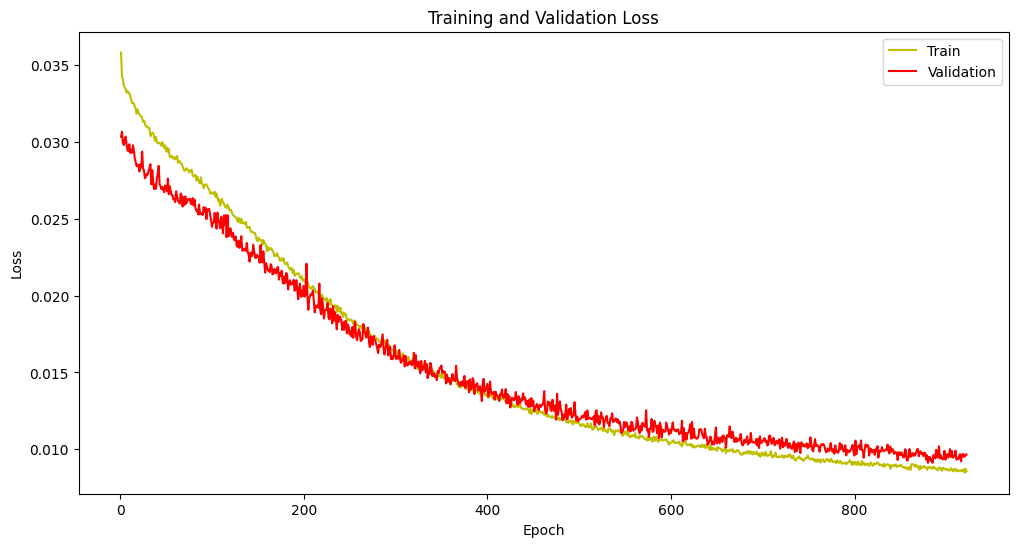

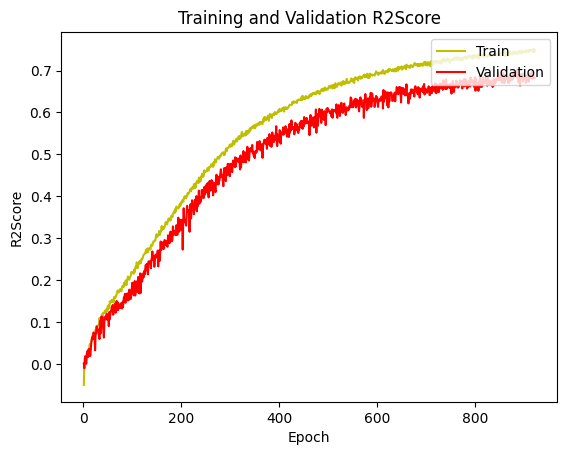

154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


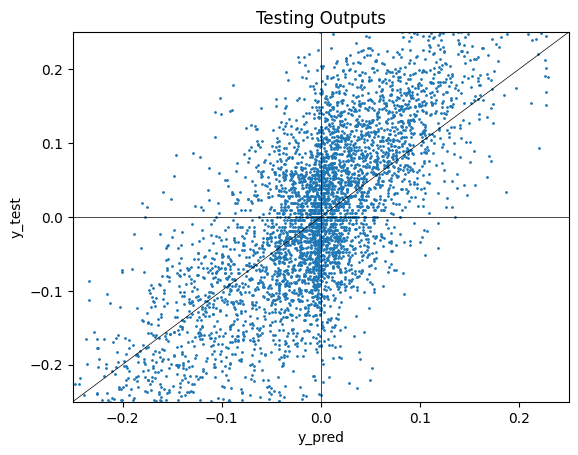

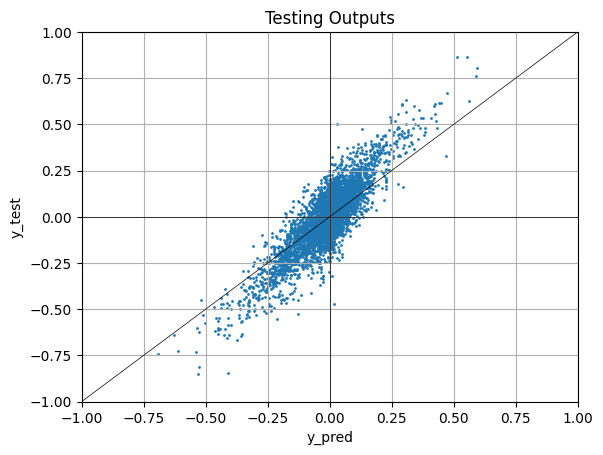

In [11]:
#JJ McCauley + LOGAN KELSCH 

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from funcs_data_preprocess import *

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('catted_1-8.csv')


testFor = 'r30'
timeSteps = 10
tType = testFor[0]
#testing random feature drops
#TREND

data = data.drop(columns=['FT','FT.1'])
#data = data.drop(columns=['FT'])
#--------------------------------------
#targets-------------------------------
#r----  1   2   3   5   10  15  30  60
data = target_setter(data, testFor)
#data['Dr3_Model'] = 0
#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)
#PROCESS THE DATA-------------------------------------------------------

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

'''
    here is where I will implement PCA.
    This text block is the explanation for the
        requirements - of using PCA in this function
        Overview - of the rest of data prep in this file

    Requirements:
        -   we will have to seperate off any time datapoints that are
            essential for proper data filtering before testing.
            -   This will include market open or time of day,
                This is so that the PCA transformation can be
                applied to the dataset, tod and mo can be appended back on,
                dataset can be normalized.
    
    Overview:
        -   normalize dataset
        -   deattach TOD and MO
        -   apply PCA function to rest of dataset
        -   append TOD and MO to dataset
        -   create lstm
        -   filter out unwanted data (market closed ,, afternoon)
        -   consider shuffling ONLY train data if you can shuffle after each epoch

    Logan Kelsch
'''
test_size       = 0.2
num_isol_feats  = 3
comps_PCA       = 10

#normalized values
t0930           = -0.32007092
t1045           = -0.141503587
t1200           = 0.03706375

X = normalize_from_tt_split(X, X, test_size)
X = reform_with_PCA_isolated(X, X, test_size, num_isol_feats, comps_PCA)
X = reformat_to_lstm(X, timeSteps)

y = y[timeSteps:]
y = np.array(y)

print('\nX shape == {}.'.format(X.shape))
print('y shape == {}.\n'.format(y.shape))



print(f'Raw Sample Count:\t{len(X)}')
X, y = remove_zero_mo_samples(X, y, timeSteps)
X, y = remove_extra_filter(X, y, timeSteps, t0930, t1200)
print(f'Remaining Sample Count:\t{len(X)}')

X = X[:,:,:-1]
#mos = X[:, timeSteps-1, len(Xfeatures)-1].mean()
#print(mos)
#print(len(X))
#print(X[0])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#to remove overlapping values that were left from training set
X_test = X_test[timeSteps:]
y_test = y_test[timeSteps:]

print('\nX_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_test shape == {}.'.format(X_test.shape))
print('y_test shape == {}.\n'.format(y_test.shape))


#LEARNING RATES____________________________________________________________________________________________
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    #good rough val to start, .25, good val to end at .0015.
    #5k epoch should be: .25, 8565, .9995, true
    0.01,
    decay_steps=100,
    decay_rate=0.997,
    staircase=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.98, 
    patience=10, 
    min_lr=1e-6
)

#LOSS FUNCTION
from keras.saving import get_custom_objects
from keras.saving import register_keras_serializable
get_custom_objects().clear()
#CUSTOM LOSS 1_______________________________________________________________________________________________
from keras.src import ops
from keras.src.losses.loss import squeeze_or_expand_to_same_rank
@register_keras_serializable(name="skew_loss")
def skew_loss(y_true,y_pred,sFact=4):
    #return ops.mean(ops.square((y_pred-y_true)*(1+sFact*tf.cast(((y_true>0 & y_pred<y_true) | (y_true<0 & y_pred>y_true)),tf.float32))),axis=-1)
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = ops.convert_to_tensor(y_true, dtype=y_pred.dtype)
    #y_true, y_pred = squeeze_or_expand_to_same_rank(y_true, y_pred)
    error = ops.subtract(y_pred, y_true)
    a = ops.convert_to_tensor(ops.cast(y_pred > 0,tf.float32), dtype=tf.float32)
    b = ops.convert_to_tensor(ops.cast(y_pred < 0,tf.float32), dtype=tf.float32)
    c = ops.convert_to_tensor(ops.cast(y_true >= y_pred*.9,tf.float32), dtype=tf.float32)
    d = ops.convert_to_tensor(ops.cast(y_true <= y_pred*.9,tf.float32), dtype=tf.float32)
    e = ops.convert_to_tensor(ops.cast(y_true > 0,tf.float32), dtype=tf.float32)
    f = ops.convert_to_tensor(ops.cast(y_true < 0,tf.float32), dtype=tf.float32)
    #e = ops.convert_to_tensor(ops.cast(y_true >= 0.05,tf.float32), dtype=tf.float32)
    #f = ops.convert_to_tensor(ops.cast(y_true <= -0.05,tf.float32), dtype=tf.float32)
    h = ops.convert_to_tensor(2, dtype=error.dtype)
    return ops.mean(
        ops.where(
            a*f+b*e==1,# or (b and d),
            h*ops.square(error),
            ops.square(error)
        ))

opt1 = SGD(learning_rate=0.01)
opt2  = tf.keras.optimizers.Adam(learning_rate=0.001)
opt3 = SGD(learning_rate=lr_schedule)
opt4 = SGD(learning_rate=0.01, momentum=0.9)
opt5 = tf.keras.optimizers.Adam(learning_rate=0.001)

#BUILD AND LOAD MODEL__________________________________________________________________________________________


#print(X_train.shape[0]/time_steps)
#X_train = np.reshape(X_train,((X_train.shape[0]//time_steps), time_steps, 35))  # Reshape to (batch_size, 5 time steps, 35 features)
#y_train = y.reshape(1,-1)
from tensorflow.keras import regularizers

def build_LSTM_model():
    #time_steps=5
    n_features=len(Xfeatures)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
        #tf.keras.layers.LSTM(256, activation='tanh', recurrent_dropout=0.3, return_sequences=True),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.LSTM(128, activation='tanh', recurrent_dropout=0.1, return_sequences=False),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),#,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),#,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=opt4,
                  loss='mse'
                  ,metrics=['R2Score','root_mean_squared_error'])
    return model

def load_model():
    #loaded_model = tf.keras.models.load_model('tupleTrain.keras', custom_objects={'custom_loss':custom_loss})
    loaded_model = tf.keras.models.load_model('r30_10s_LSTM_8.keras')
    loaded_model.compile(optimizer=opt4,
                         loss=skew_loss
                         , metrics=['R2Score','root_mean_squared_error'])
    return loaded_model

#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 2000

early_stopping = EarlyStopping(monitor='val_loss', patience=42, mode='min', restore_best_weights=True)

cmp = 'C'
if tf.config.list_physical_devices('GPU'):
    cmp = 'G'
    pass
with tf.device('/'+cmp+'PU:0'):
    print('Running on: '+cmp+'PU\n')
    model = build_LSTM_model()
    #loaded_model = load_model()
    used_model = model
    history = used_model.fit(X_train, y_train, epochs=epochs,\
                        shuffle=True, verbose=1, validation_data=(X_test, y_test),\
                        batch_size=15,callbacks=[reduce_lr, early_stopping])

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

#show_all_results(used_model, history, X_test, y_test)

# LOSS
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'], 'y', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# ACCURACY

plt.plot(epochs, history.history['R2Score'], 'y', label='Training R2')
plt.plot(epochs, history.history['val_R2Score'], 'r', label='Validation R2')
plt.title('Training and Validation R2Score')
plt.xlabel('Epoch')
plt.ylabel('R2Score')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


#predicting the test set results
y_pred = used_model.predict(X_test) 


plt.scatter(y_pred, y_test, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-.25,.25)
plt.ylim(-.25,.25)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

#SCATTERPLOT #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  
plt.scatter(y_pred, y_test, s=1)
plt.grid()
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

In [12]:
used_model.save('r30_PCA10_2.keras')

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def walk_forward_validation(X, y, model, n_splits=20, test_size=0.2):
    """
    Perform walk-forward validation for an LSTM model.

    Parameters:
    X (np.ndarray): 3D array of features with shape (n_samples, time_steps, n_features)
    y (np.ndarray): 1D array of labels with shape (n_samples,)
    model (tf.keras.Model): Compiled LSTM model
    n_splits (int): Number of walk-forward splits
    test_size (float): Proportion of the data to use as the test set in each split

    Returns:
    list: MSE scores for each split
    """
    n_samples = X.shape[0]
    test_set_size = int(test_size * n_samples)
    
    mse_scores = []

    # Split the data into n_splits segments
    for i in range(n_splits):
        # Define the index range for the training set (everything before the test set)
        train_end = int((i + 1) * (n_samples - test_set_size) / n_splits)

        # Define the test set
        X_train, X_test = X[:train_end], X[train_end:train_end + test_set_size]
        y_train, y_test = y[:train_end], y[train_end:train_end + test_set_size]

        # Ensure that your model is recompiled and retrained in each fold
        model_copy = tf.keras.models.load_model(model)
        model_copy.compile(optimizer='adam', loss='mse')  # Assuming MSE for regression

        # Fit the model on the current training set
        model_copy.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        # Make predictions on the test set
        y_pred = model_copy.predict(X_test)

        # Calculate the mean squared error for this fold
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

        print(f'Fold {i+1}/{n_splits}, MSE: {mse}')

    return mse_scores

# Example usage:
# Assuming you have already defined `X`, `y`, and compiled your LSTM model
# mse_scores = walk_forward_validation(X, y, lstm_model, n_splits=5, test_size=0.2)
X_vals = X_test
y_vals = y_test
print('X shape:',X_vals.shape,'\ny shape:',y_vals.shape)
scores = walk_forward_validation(X_test, y_test, 'LSTM_testtest.keras')
avgScore = 0
for score in scores:
    avgScore+=score
avgScore/=len(scores)

print('Average MSE:',avgScore)

In [ ]:
data.corr()

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
new_model = tf.keras.models.load_model("r30_PCA10_1.keras")

y_pred = new_model.predict(X_test) 


plt.scatter(y_pred, y_test, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-.25,.25)
plt.ylim(-.25,.25)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

#SCATTERPLOT #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  
plt.scatter(y_pred, y_test, s=1)
plt.grid()
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()